# Import Library, Load Data

## FULC

*Fully connected layer* 을 주로 이용한 이 방법은

input에 이용되는 Feature : 날씨-평균기온, 날씨-평균습도, 날씨-평균바람, 날씨-강수량, 날씨-최고기온 <br>

<br>
** EDA 결과, 날씨-최고기온 / 날씨-평균기온과 커피 검색량은 + correlation 을 보였고, 
바람과 강수량에서는 명확한 관계는 보이지 않았으나, log 곡선을 타지 않을까 조심스럽게 예측해 본다. 윤영님같은 경우, 강수량을 0,1,2 로 재정의해서 사용하는 아이디어를 제안하였는데, 다양한 방법을 다 적용해 보는걸로.<br>

try 1 : 당일 날씨-평균기온, 당일 날씨-평균습도, 당일 날씨-평균바람, 당일 날씨-강수량, 당일 날씨-최고기온 <br>
try 2 : 당일 날씨-평균기온, 당일 날씨-평균습도, 당일 날씨-평균바람(log), 당일 날씨-강수량(log), 당일 날씨-최고기온 <br>
try 3 : 당일 날씨-평균기온, 당일 날씨-평균습도, 당일 날씨-평균바람(012), 당일 날씨-강수량(012), 당일 날씨-최고기온 <br>
try 4 : 요일별도 적용해 보는걸로.

In [403]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

In [404]:
def importDataset(name) :
    print('kind of dataset : all, coco, ia, icetea, juice, latte')
    print('import dataset : ', name , '\n\n')
    dataset = pd.read_csv('bev_' + name + '_weather.csv', index_col = 0)
    print(dataset.head())
    print('\n\n')
    return dataset

def removeUnimportantColumns(dataframe) : 
    new_dataframe = dataframe.drop([
        'datetime',
        'weather.stn_id',
        'weather.min_ta',
    ], axis = 1)
    print(new_dataframe.columns)
    return new_dataframe

df_ia = importDataset('ia')
df_ia = removeUnimportantColumns(df_ia)

kind of dataset : all, coco, ia, icetea, juice, latte
import dataset :  ia 


     datetime       ia  weather.stn_id  weather.max_ta  weather.max_ws  \
0  2016-01-01  5.40897      444.851852        5.025926        2.674074   
1  2016-01-02  6.33245      444.851852       10.151852        3.283333   
2  2016-01-03  8.97097      444.851852        9.448148        2.557407   
3  2016-01-04  8.70712      444.851852        6.605556        4.287037   
4  2016-01-05  7.12401      444.851852        1.679630        3.811111   

   weather.min_ta  weather.avg_ta  weather.avg_rhm  weather.avg_wa  \
0       -4.098148        1.074074        77.076923        0.911111   
1        1.650000        5.642593        78.358974        1.231481   
2        2.598148        5.533333        84.461538        0.746296   
3       -2.259259        2.598148        55.102564        2.018519   
4       -4.794444       -2.013208        41.684211        1.607407   

   weather.sum_rn  rn_label  weekday  
0             0.0

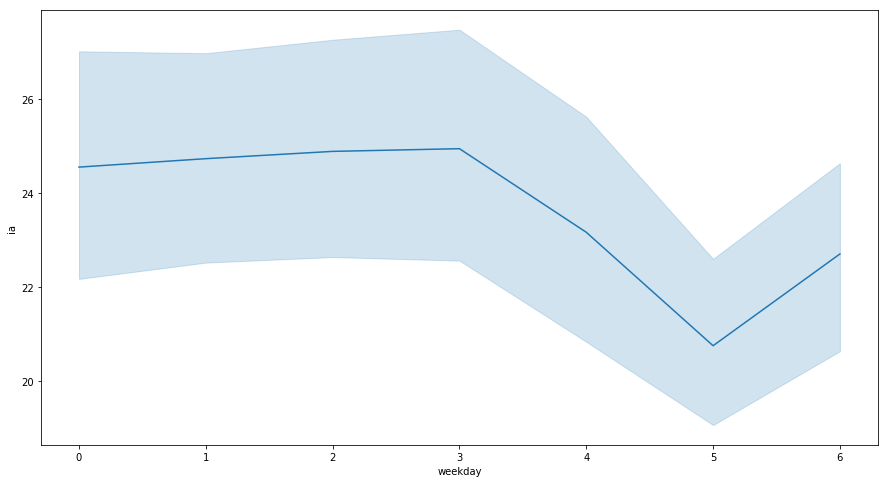

In [405]:
plt.figure(figsize = [15, 8])
sns.lineplot(x = df_ia['weekday'], y = df_ia['ia'])

# Model

In [406]:
# DNN : Deep Neural Network

## Hyper parameters

In [372]:
#about training
learning_rate = 0.01
step = 10000


def set_activation_function(string):
    print('activation function :',string, '\n\n')
    if string == 'tanh' :
        return tf.tanh, string
    elif string == 'relu' :
        return tf.nn.relu, string
    elif string == 'lrelu' :
        return tf.nn.leaky_relu, string

#activation function
activation_function, activation_functionname = set_activation_function('lrelu') #relu

activation function : lrelu 




<h4>Kinds of Hyper parameters</h4>

#### LSTM
- timesteps : <br>
- data_dim : data dimension <br>
- hidden_layer_size <br>
- hidden_dim = hidden_dimension <br>
    - https://stackoverflow.com/questions/37901047/what-is-num-units-in-tensorflow-basiclstmcell <br>
    - more hidden dimension, more memorize <br>
    
#### DNN    


## Data Pre-Processing

In [373]:
def select_weekday(data, *weekname_args) :
    print('function input : \n' , data.head())
    select_weekday_val = []
    original_weekday_val = [0,1,2,3,4,5,6]
    data_return = data.copy()
    
    if 'mon' in weekname_args :
        select_weekday_val.append(0)
    if 'tue' in weekname_args :
        select_weekday_val.append(1)
    if 'wed' in weekname_args :
        select_weekday_val.append(2)
    if 'thu' in weekname_args :
        select_weekday_val.append(3)
    if 'fri' in weekname_args :
        select_weekday_val.append(4)
    if 'sat' in weekname_args :
        select_weekday_val.append(5)    
    if 'sun' in weekname_args :
        select_weekday_val.append(6)

    print(data_return.head())
    for i in select_weekday_val :
        tmpdata = data_return.drop(index = (data_return.loc[(data_return['weekday'] == i) == True]).index)
        data_return = tmpdata

    print(data_return.weekday.unique())
    return data_return
    

def select_for_train_and_test(data, *columnname_args) :        
    drop_column = []
    for column in columnname_args :
        drop_column.append(column)
    
    df_xy = data.drop(drop_column, axis = 1)
    print(df_xy.columns)
    return df_xy


#df_ia_weekday_selected = select_weekday(df_ia, 'mon', 'tue', 'wed', 'thu')
df_ia_weekday_selected = select_weekday(df_ia, 'fri', 'sat', 'sun')
df_xy = select_for_train_and_test(df_ia_weekday_selected, 'weather.max_ws', 'weather.max_ta', 'rn_label', 'weekday')
np_xy = df_xy.to_numpy()
batch_size = np_size = len(np_xy)
np_xy

function input : 
         ia  weather.max_ta  weather.max_ws  weather.avg_ta  weather.avg_rhm  \
0  5.40897        5.025926        2.674074        1.074074        77.076923   
1  6.33245       10.151852        3.283333        5.642593        78.358974   
2  8.97097        9.448148        2.557407        5.533333        84.461538   
3  8.70712        6.605556        4.287037        2.598148        55.102564   
4  7.12401        1.679630        3.811111       -2.013208        41.684211   

   weather.avg_wa  weather.sum_rn  rn_label  weekday  
0        0.911111             0.0         0        4  
1        1.231481             0.0         0        5  
2        0.746296             0.0         0        6  
3        2.018519             0.0         0        0  
4        1.607407             0.0         0        1  
        ia  weather.max_ta  weather.max_ws  weather.avg_ta  weather.avg_rhm  \
0  5.40897        5.025926        2.674074        1.074074        77.076923   
1  6.33245       1

array([[ 8.70712   ,  2.59814815, 55.1025641 ,  2.01851852,  0.        ],
       [ 7.12401   , -2.01320755, 41.68421053,  1.60740741,  0.        ],
       [ 5.80474   , -1.35185185, 59.20512821,  1.19259259,  0.        ],
       ...,
       [12.53298   , -1.2245283 , 40.64102564,  2.14150943,  0.        ],
       [13.06068   , -9.40377358, 29.61538462,  2.8509434 ,  0.        ],
       [ 9.76253   , -6.20377358, 50.56410256,  0.98490566,  0.        ]])

In [374]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


def StandardScaler(data):
#    avg = []
#    for i in range(0, np_xy[0], 1) :
#        np.mean(np_xy[:,i])
    avg = np.mean(np_xy, axis = 0)
    std = np.std(np_xy, axis = 0)
    
    final = (data - avg) / std
    
    return final


def LogScaler(data) :
    pass


#scaled_np_xy = MinMaxScaler(np_xy)
scaled_np_xy = StandardScaler(np_xy)

scaled_np_xy

array([[-1.0614027 , -0.92093257, -0.545331  ,  0.80190587, -0.27602831],
       [-1.16593985, -1.34398415, -1.46779634,  0.05764652, -0.27602831],
       [-1.2530549 , -1.28331054, -0.26329392, -0.69331786, -0.27602831],
       ...,
       [-0.80877056, -1.27162972, -1.53951169,  1.02456378, -0.27602831],
       [-0.77392507, -2.02200397, -2.29748633,  2.30889505, -0.27602831],
       [-0.99171106, -1.72843195, -0.85733451, -1.0693061 , -0.27602831]])

In [375]:
# train/test split
train_size = int(len(scaled_np_xy) * 0.7)
train_set = scaled_np_xy[0:train_size]
test_set = scaled_np_xy[train_size:]
print('train size : ', train_size)
print('test size : ', len(test_set))
# Index from [train_size - seq_length] to utilize past sequence

train size :  437
test size :  188


In [376]:
# build datasets
def build_dataset(dataset, target_column):
    
    dataset_X = []
    column_array = []
    column_array = list(range(0, len(dataset[0])))
    column_array.remove(target_column)
    print(column_array)
    
    return dataset[:,column_array], dataset[:,target_column]

trainX, trainY = build_dataset(train_set, 0)
testX, testY   = build_dataset(test_set , 0)

[1, 2, 3, 4]
[1, 2, 3, 4]


In [377]:
trainY = trainY.reshape(-1, 1)
print(np.shape(trainX), np.shape(trainY))
testY = testY.reshape(-1,1)
print(np.shape(testX), np.shape(testY))

(437, 4) (437, 1)
(188, 4) (188, 1)


## DNN Model

In [378]:
X = tf.placeholder(tf.float32, [None, len(trainX[0])])
Y = tf.placeholder(tf.float32, [None, 1])

In [379]:
w1 = tf.Variable(tf.random_normal([len(trainX[0]), len(trainX[0])]), name = 'weight1')
b1 = tf.Variable(tf.random_normal([len(trainX[0])]), name = 'bias1')
layer1 = activation_function(tf.add(tf.matmul(X, w1), b1))

w2 = tf.Variable(tf.random_normal([len(trainX[0]), len(trainX[0])]), name = 'weight2')
b2 = tf.Variable(tf.random_normal([len(trainX[0])]), name = 'bias2')
layer2 = activation_function(tf.add(tf.matmul(layer1, w2), b2))


w3 = tf.Variable(tf.random_normal([len(trainX[0]), len(trainX[0])]), name = 'weight3')
b3 = tf.Variable(tf.random_normal([len(trainX[0])]), name = 'bias3')
layer3 = activation_function(tf.add(tf.matmul(layer2, w3), b3))


w4 = tf.Variable(tf.random_normal([len(trainX[0]), len(trainX[0])]), name = 'weight4')
b4 = tf.Variable(tf.random_normal([len(trainX[0])]), name = 'bias4')
layer4 = activation_function(tf.add(tf.matmul(layer3, w4), b4))


w5 = tf.Variable(tf.random_normal([len(trainX[0]), len(trainX[0])]), name = 'weight5')
b5 = tf.Variable(tf.random_normal([len(trainX[0])]), name = 'bias5')
layer5 = activation_function(tf.add(tf.matmul(layer4, w5), b5))



finalw = tf.Variable(tf.random_normal([len(trainX[0]), 1]), name = 'finalweight')
finalb = tf.Variable(tf.random_normal([1]), name = 'finalbias')
output_layer = activation_function(tf.add(tf.matmul(layer1, finalw), finalb))


print(output_layer)

Tensor("LeakyRelu_43:0", shape=(?, 1), dtype=float32)


In [380]:
cost = tf.reduce_mean(tf.square(output_layer - Y))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate)

train = optimizer.minimize(cost)

In [381]:
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
print(targets, '\n', predictions, '\n', rmse)

np.shape(testX)
np.shape(testY)

Tensor("Placeholder_97:0", shape=(?, 1), dtype=float32) 
 Tensor("Placeholder_98:0", shape=(?, 1), dtype=float32) 
 Tensor("Sqrt_35:0", shape=(), dtype=float32)


(188, 1)

In [400]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(step):
        _, step_loss = sess.run([train, cost], feed_dict={
                                X: trainX, Y: trainY})

    test_predict = sess.run(output_layer, feed_dict={X: testX})
    train_predict = sess.run(output_layer, feed_dict= {X: trainX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict.reshape(-1,1)})
    print("RMSE: {}".format(rmse_val))


RMSE: 0.6493271589279175


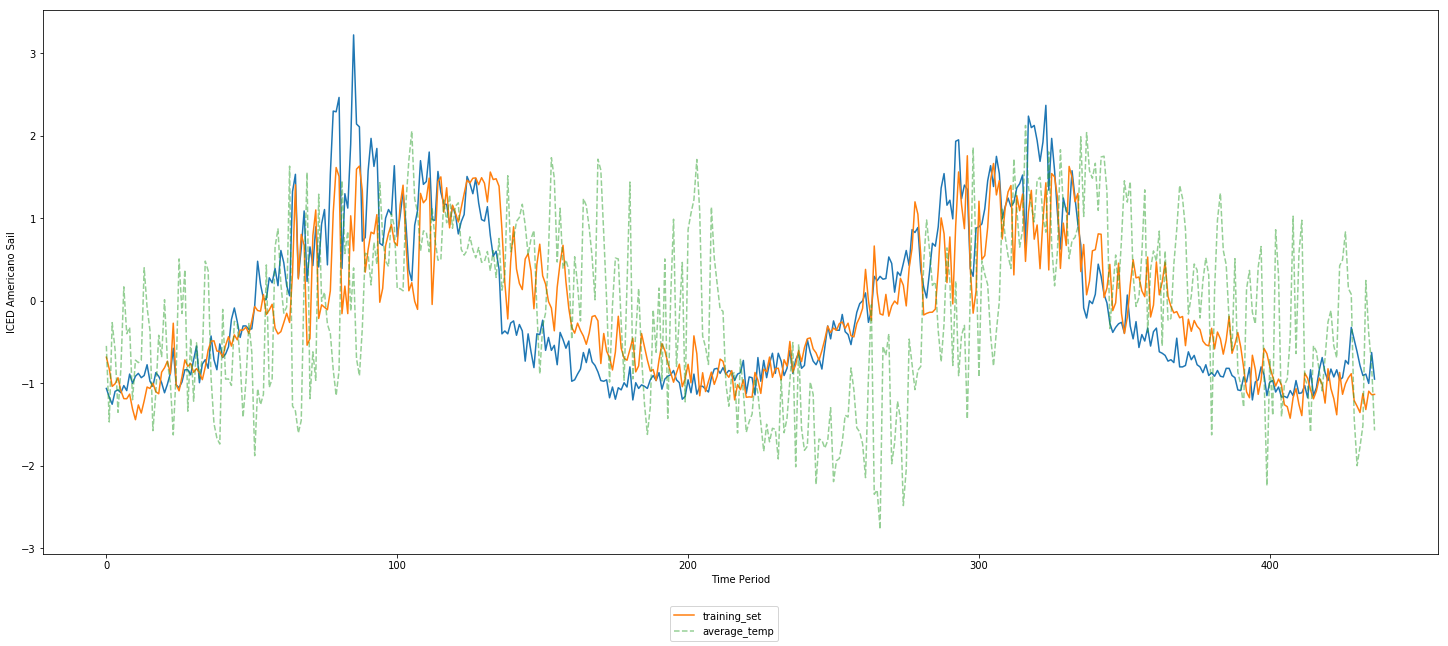

In [401]:
ax = plt.figure(figsize = [25,10])
plt.plot(trainY[:])
plt.plot(train_predict[:], label = 'training_set')
plt.plot(trainX[:,1], label = 'average_temp', alpha= 0.5, linestyle='dashed')
plt.xlabel("Time Period")
plt.ylabel("ICED Americano Sail")
ax.legend(loc = 8)
plt.show()

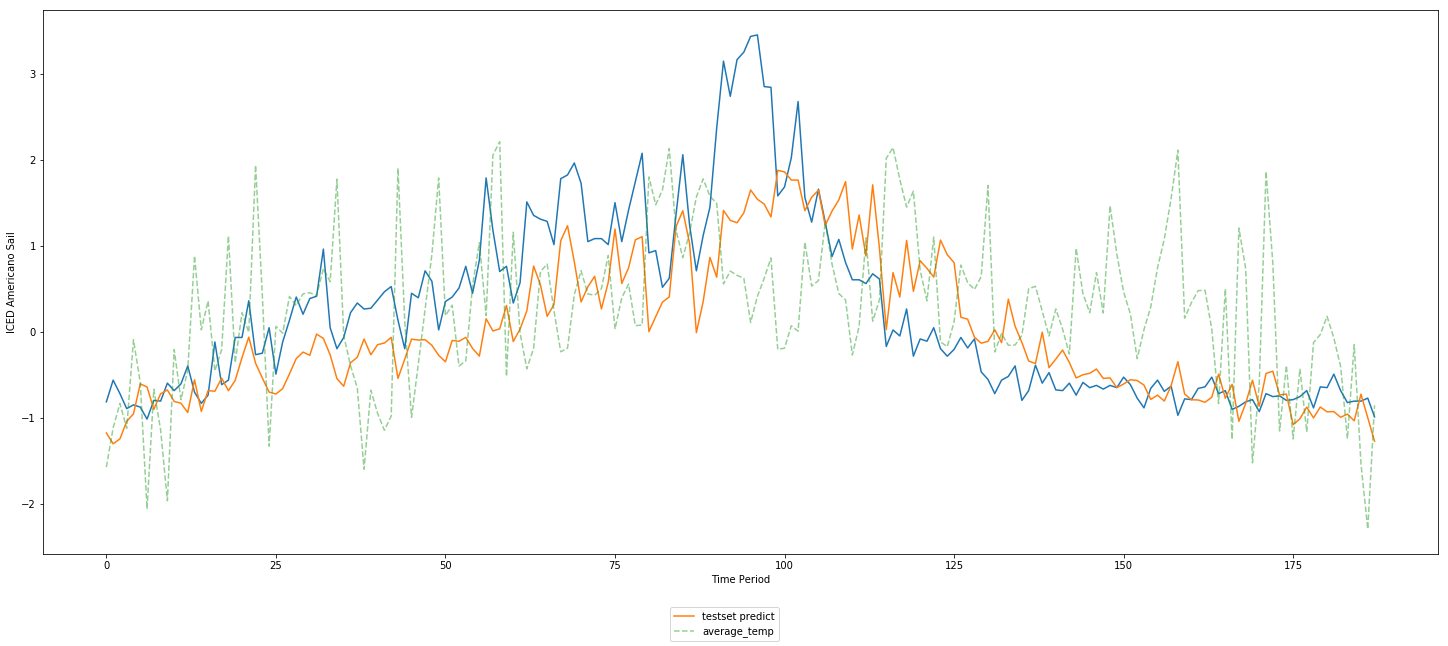

In [402]:
# plot predictions
ax = plt.figure(figsize= [25,10])
plt.plot(testY[:, 0])
plt.plot(test_predict[:, 0], label = 'testset predict')
plt.plot(testX[:,1], label = 'average_temp', alpha = 0.5, linestyle='dashed' )
plt.xlabel("Time Period")
plt.ylabel("ICED Americano Sail")
ax.legend(loc = 8)
plt.show()

## 아무리 학습을 시켜도...

저기 내려가는 부분이 경향을 파악하지 못함. 하지만 놀라울 정도로 예측을 잘하는 경우도 존재함. 분명히 날씨변수만 넣었음에도 이런 추세를 따라가는 것은 분명히 어느정도 상관관계가 있다는 것을 알 수 있음.